In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt      
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MultipleLocator



NB_CONTEXT_TYPES = 10
context_to_num = {'full context': 0, 'incongruent context':1, 
                  'no context':2, 'no object':3, 'blur context':4, 
                  'blur object':5, 'blur boundary':6, 'min context':7, 
                  'jigsaw context':8, 'textured context':9}
num_to_context = {value: key for key, value in context_to_num.items()}

custom_colors=['#174173','#0B4F26','#C53F3B']
color_palette_gradient = sns.color_palette("Greys", n_colors=7)
q=['#8856a7', '#d95f02', '#636363', '#ffd92f', '#a6cee3', '#e7298a', '#1b9e77']
# Combine the custom and gradient palettes
combined_palette = custom_colors + color_palette_gradient
LABEL_SIZE=25
TICKS_SIZE=25


In [16]:
subject = 'human'
human_data = pd.read_csv(f'../subject_data/human_ver2.csv')
monkey_data = pd.read_csv(f'../subject_data/monkeys.csv')
data_to_use = monkey_data if subject =='monkey' else human_data
valid_info = data_to_use[(data_to_use['isValidSample_Test']==1)&(data_to_use['isValidSample']==1)].sort_values(by=['imageNr'])
valid_info['context cat'] = valid_info['imageNr'] % NB_CONTEXT_TYPES


In [4]:
context_grouped = valid_info.groupby('imageNr').aggregate(np.nanmean).groupby('context cat')
mean_human=context_grouped.aggregate(np.nanmean)['Response']
std_human=context_grouped.aggregate(np.nanstd)['Response']

In [5]:
p_values=[]
for i in range(9):
    context_type_1 = context_grouped.aggregate(lambda x:list(x))['Response'][i]
    context_type_2 = context_grouped.aggregate(lambda x:list(x))['Response'][i+1]
    t_stat, p_value = stats.ttest_ind(context_type_1, context_type_2)
    p_values.append(p_value)

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3468/159410775.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.barplot(data=df, x=df.index, y='mean', ec="black", linewidth=1.5,
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_3468/159410775.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(context_to_num.keys()), rotation=10)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


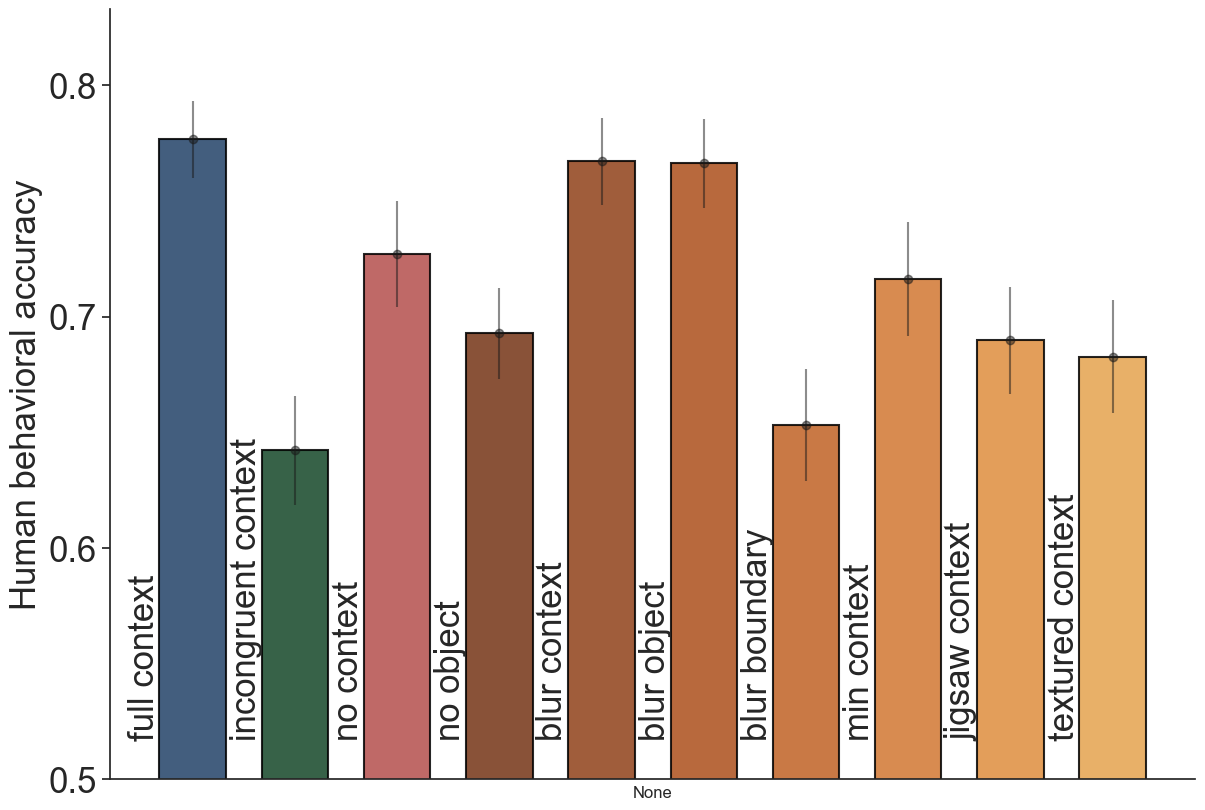

{'human'}

In [7]:
sns.set(rc={"figure.figsize":(14, 10)})

q=['#636363','#a6cee3', '#d95f02', '#1b9e77', '#fb9a99','#e6ab02','#8856a7' ]
color_palette_gradient=sns.color_palette("YlOrBr_r",12)[:7]#sns.color_palette("mako", 12)[:7]
# Combine the custom and gradient palettes
combined_palette = custom_colors + color_palette_gradient#ualitative_colors[:7]#+qualitative_colors[5:]##color_palette_gradient[:]


sns.set_theme(style="white")
sns.set_style('ticks') 
df =pd.DataFrame(mean_human.values, columns=['mean'])
df['std']=std_human
ax =sns.barplot(data=df, x=df.index, y='mean', ec="black", linewidth=1.5,
                 palette=combined_palette, alpha=0.85,width=0.65)
sns.despine()
plt.errorbar(x=list(df.index), y=mean_human.values, yerr=std_human.values.squeeze()/np.sqrt(60),fmt='o' , color='k', alpha=0.5)
plt.ylim(0.5)
plt.ylabel(f'{subject.capitalize()} behavioral accuracy', fontsize=LABEL_SIZE)
ax.set_xticklabels(list(context_to_num.keys()), rotation=10)
plt.tick_params(axis='y', labelsize=TICKS_SIZE) 
# Add p-value annotations to the bars
#for i, p_value in enumerate(p_values):
#    ax.annotate(f'p={p_value:.3f}', (i+0.5, max(mean_human.values[i],mean_human.values[i+1])  +0.01), ha='center', fontsize=10, color='r' if p_value < 0.05 else 'k')
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.1))
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() -0.15, 0.52,list(context_to_num.keys())[i], ha='center', rotation=90, fontsize=LABEL_SIZE)
plt.xticks([])
plt.savefig(f'{subject}_beh_col.eps')
plt.show()

In [8]:
context_list=context_grouped.aggregate(lambda x: list(x))['Response']
delta_incong= (np.array(context_list[0])-np.array(context_list[1]))
print(f'Mean {subject} congruent vs incongruent {delta_incong.mean()}, std {delta_incong.std()}')


Mean human congruent vs incongruent 0.13425742744179078, std 0.20805095863597772


In [10]:
import statsmodels.api as sm
for i in range(9):
    for j in range(i+1, 10):
        context_type_1 = context_grouped.aggregate(lambda x:list(x))['Response'][i]
        #print(context_type_1)
        context_type_2 = context_grouped.aggregate(lambda x:list(x))['Response'][j]
        ksstat1, pvalue1 =sm.stats.diagnostic.lilliefors(context_type_1)
        ksstat2, pvalue2 =sm.stats.diagnostic.lilliefors(context_type_2)
        if pvalue1>0.05:
            print(num_to_context[i]+ f" {np.round(pvalue1,3)} Normal")
        else:
            print(num_to_context[i] + f" {np.round(pvalue1,3)} Not Normal")
        if pvalue2>0.05:
            print(num_to_context[j]+ f" {np.round(pvalue2,3)} Normal")
        else:
            print(num_to_context[j] + f" {np.round(pvalue2,3)} Not Normal")

        t_stat, p_value = stats.ttest_ind(context_type_1, context_type_2)
        if p_value < 0.05:
            print(f'Statistically significant p-value({np.round(p_value,5)}) t-value({np.round(t_stat,5)}) for {num_to_context[i]} and {num_to_context[j]}')
        t_stat, p_value = stats.ranksums(context_type_1, context_type_2)
        if p_value < 0.05:
            print(f'Wilcoxon Statistically significant p-value({np.round(p_value,5)}) t-value({np.round(t_stat,5)}) for {num_to_context[i]} and {num_to_context[j]}')



full context 0.004 Not Normal
incongruent context 0.371 Normal
Statistically significant p-value(1e-05) t-value(4.66512) for full context and incongruent context
Wilcoxon Statistically significant p-value(1e-05) t-value(4.39574) for full context and incongruent context
full context 0.004 Not Normal
no context 0.001 Not Normal
full context 0.004 Not Normal
no object 0.422 Normal
Statistically significant p-value(0.00137) t-value(3.27926) for full context and no object
Wilcoxon Statistically significant p-value(0.0006) t-value(3.43261) for full context and no object
full context 0.004 Not Normal
blur context 0.002 Not Normal
full context 0.004 Not Normal
blur object 0.001 Not Normal
full context 0.004 Not Normal
blur boundary 0.244 Normal
Statistically significant p-value(5e-05) t-value(4.20025) for full context and blur boundary
Wilcoxon Statistically significant p-value(0.00012) t-value(3.84988) for full context and blur boundary
full context 0.004 Not Normal
min context 0.001 Not Norm

In [11]:
import statsmodels.api as sm
ksstat, pvalue = sm.stats.diagnostic.lilliefors(context_grouped.aggregate(lambda x:list(x))['Response'][1])
if pvalue>0.05:
    print("humans " + f" {np.round(pvalue,3)} Normal")
else:
    print("humans " + f" {np.round(pvalue,3)} Not Normal")

humans  0.371 Normal


In [20]:
all_images = valid_info.groupby('imageNr')
agg_functions = {
    'context cat':  np.nanmean,   
    'Response':   lambda x:list(x)
}

mean_image = all_images.aggregate(np.nanmean).groupby('context cat').aggregate(lambda x:list(x))['Response']
congruent_acc = mean_image[0]
incongruent_acc = mean_image[1]
nocontext_acc = mean_image[2]
all_images_agg = all_images.aggregate(agg_functions)

all_images_agg['SEM'] = [np.nanstd(v)/np.sqrt(len(v)) for v in all_images_agg['Response'].values]
sem = all_images_agg[['Response', 'context cat', 'SEM']].groupby('context cat').aggregate(lambda x:list(x))['SEM']
all_images_agg['SEM']


imageNr
0      0.068998
1      0.085601
2      0.075661
3      0.084481
4      0.072747
         ...   
595    0.041536
596    0.039235
597    0.056552
598    0.042791
599    0.054772
Name: SEM, Length: 600, dtype: float64

In [24]:
color_palette_objects = sns.color_palette("Greys", n_colors=10)
group_colors = np.repeat(color_palette_objects, 6, axis=0)
object_lb = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra'];


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


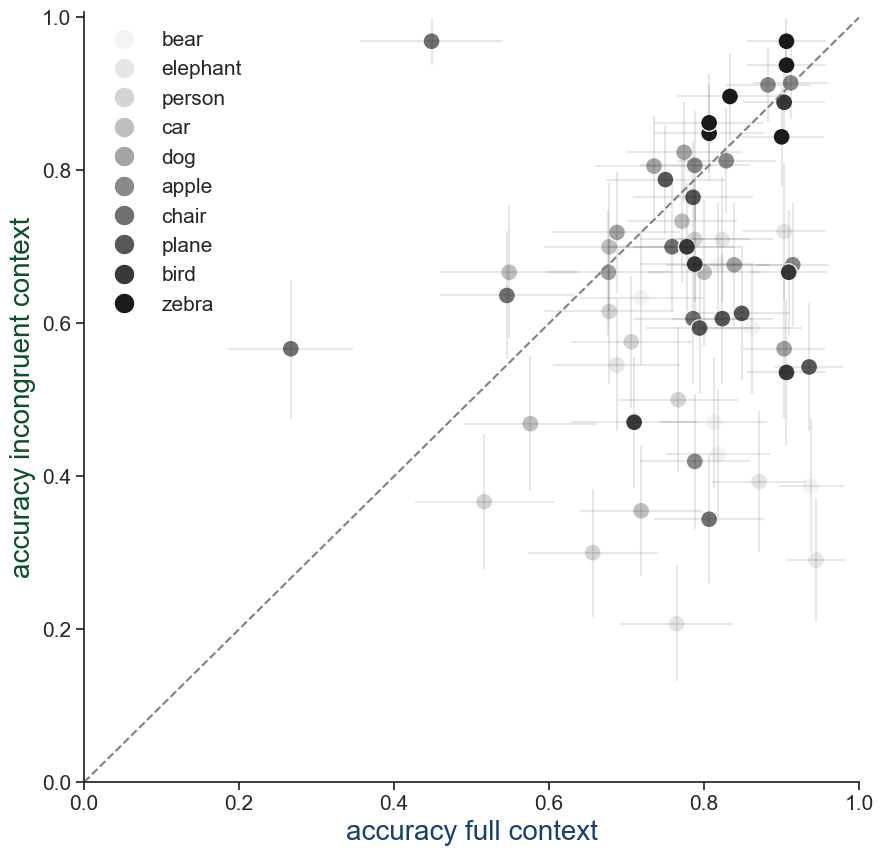

In [28]:
limit_l = 0
sns.set(rc={"figure.figsize":(10, 10)})
sns.set_theme(style="white"), sns.set_style('ticks') 
df = pd.DataFrame(congruent_acc, columns=['full context'])
df['incongruent context'] = incongruent_acc
ax = sns.scatterplot(data= df, x='full context', y='incongruent context', s=150,  c=group_colors, label=object_lb)
ax.set_ylim(limit_l)
ax.set_xlim(limit_l,1)
plt.errorbar(df['full context'], df['incongruent context'], xerr=sem[0], yerr=sem[1], fmt='none', color='k', label="Error Bars", alpha=0.1)
plt.tick_params(axis='y', labelsize=TICKS_SIZE) 

plt.tick_params(axis='x', labelsize=TICKS_SIZE) 


legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=object_lb[i],markersize=15,
                            markerfacecolor=color) for i, color in enumerate(color_palette_objects)]

# Add the legend to the plot
plt.legend(handles=legend_labels, loc='upper left',frameon=False, fontsize=15)

sns.despine()
ax.set_xlabel('accuracy full context', fontsize=LABEL_SIZE, c='#174173')
ax.set_ylabel('accuracy incongruent context', fontsize=LABEL_SIZE, c='#0B4F26')

plt.plot([limit_l, 1], [limit_l, 1], color='grey', linestyle='--', )
plt.savefig(f'{subject}_incong_vs_cong.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


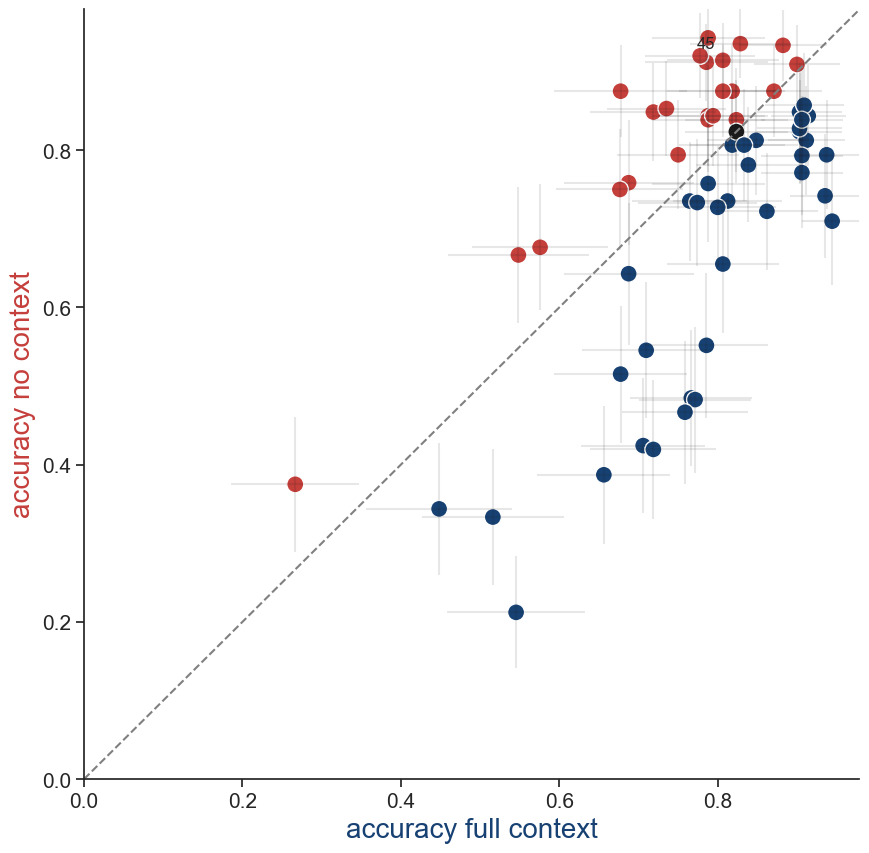

In [30]:

df = pd.DataFrame(congruent_acc, columns=['full context'])
df['incongruent context'] = incongruent_acc
df['no context'] = nocontext_acc
df['Color'] = 'k'
palette=dict(zip(custom_colors, custom_colors))
palette['k']='k'

limit_l = 0
sns.set(rc={"figure.figsize":(10, 10)})
sns.set_theme(style="white"), sns.set_style('ticks') 
context_type_x = 'full context'
context_type_y = 'no context'

c_x, c_y=custom_colors[context_to_num[context_type_x]], custom_colors[context_to_num[context_type_y]]

# Change color to blue for points where Y > X
df.loc[df[context_type_x] > df[context_type_y], 'Color'] = c_x
df.loc[df[context_type_x] < df[context_type_y], 'Color'] = c_y
ax = sns.scatterplot(data= df, x=context_type_x, y=context_type_y, s=150,  hue='Color', 
                     palette=palette, legend=False)
ax.set_ylim(limit_l)
ax.set_xlim(limit_l)
plt.errorbar(df[context_type_x], df[context_type_y], xerr=sem[context_to_num[context_type_x]], yerr=sem[context_to_num[context_type_y]], fmt='none', color='k', label="Error Bars", alpha=0.1)
plt.tick_params(axis='y', labelsize=TICKS_SIZE) 

plt.tick_params(axis='x', labelsize=TICKS_SIZE) 


sns.despine()
ax.set_xlabel(f'accuracy {context_type_x}', fontsize=LABEL_SIZE, c=c_x)
ax.set_ylabel(f'accuracy {context_type_y}', fontsize=LABEL_SIZE, c=c_y)

for index, row in df.iterrows():
    #if row[context_type_y] < (row[context_type_x]):
    if index ==45:
        plt.annotate(index, (row[context_type_x], row[context_type_y]), textcoords="offset points", xytext=(0,10), ha='center')


plt.plot([limit_l, 1], [limit_l, 1], color='grey', linestyle='--', )
plt.savefig(f'{subject}_{context_type_x}_vs_{context_type_y}.eps')
plt.show()

In [31]:
index_h = df.loc[df['no context'] < (df['full context'])].index
df.loc[df['no context'] < (df['full context'])]#13 and 32

,full context,incongruent context,no context,Color
0,0.812500,0.470588,0.735294,#174173
1,0.818182,0.676471,0.806452,#174173
3,0.937500,0.387097,0.794118,#174173
4,0.862069,0.593750,0.722222,#174173
7,0.903226,0.720000,0.823529,#174173
8,0.764706,0.206897,0.735294,#174173
9,0.944444,0.290323,0.709677,#174173
10,0.687500,0.545455,0.642857,#174173
12,0.656250,0.300000,0.387097,#174173
13,0.766667,0.500000,0.484848,#174173
